In [1]:
!pip install opendatasets

## Import required package

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
#import opendatasets as od
import cv2
from IPython import display
import imageio.v2 as imageio
import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Conv2DTranspose, ReLU, LeakyReLU, BatchNormalization,\
                                    Reshape, Activation, Dropout, Flatten
from tensorflow.keras.activations import tanh
from tensorflow.keras import initializers
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Preprare dataset

In [3]:
# Dataset link :https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses 
# od.download_kaggle_dataset("https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses", '.')

In [4]:
IMG_SIZE = 64
IMG_CHANNELS = 3

BATCH_SIZE = 256

NOISE_DIMS = 100

BUFFER_SIZE = 5000

In [5]:
def preprocessing(filepath):
  image = tf.io.read_file(filepath)
  image = tf.io.decode_png(image, channels=IMG_CHANNELS)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  image = tf.cast(image, tf.float32)
  # Scale to [-1, 1]
  image = image / 127.5 - 1

  return image

def prepare_dataset(dataset, batch_size, buffer_size, shuffle=True):
  dataset = dataset.cache()
  if shuffle:
    dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size, drop_remainder=True)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

def load_image_path(filepath):
  return filepath.numpy()

image_folder_path = '/kaggle/input/glasses-or-no-glasses/faces-spring-2020/faces-spring-2020'

dataset = tf.data.Dataset.list_files(str(os.path.join(image_folder_path, '*.png')),
                                   shuffle=False)
#dataset = dataset.map(lambda x: tf.py_function(load_image_path, [x], [tf.string]))
dataset = dataset.map(preprocessing)
dataset = prepare_dataset(dataset, BATCH_SIZE, BUFFER_SIZE, True)

## Implement Generator:

In [6]:
# I will use the DCGAN architecture for generator

class Generator(keras.Model):
    def __init__(self):
        super(Generator, self).__init__()

        self.net = keras.models.Sequential(
            [
                Dense(4 * 4 * 1024, activation='relu'),
                Reshape((4, 4, 1024)),
                self._block(filters=512, kernel_size=5, strides=2, padding='same'),
                self._block(filters=256, kernel_size=5, strides=2, padding='same'),
                self._block(filters=128, kernel_size=5, strides=2, padding='same'),
                # We will not apply the batch normalization on output and use tanh activation instead of leaky relu
                Conv2DTranspose(filters=IMG_CHANNELS, kernel_size=5, strides=2, padding='same'),
                Activation(tanh)
            ]
        )

    def _block(self, filters, kernel_size, strides, padding):
        # This will implement one fractional-kernal Conv block
        return keras.models.Sequential(
            [
                Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=strides,
                                padding=padding,
                               kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),
                               bias_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
                BatchNormalization(),
                ReLU()
            ]
        )

    def call(self, x, training=False):
        return self.net(x)

In [7]:
test_input = tf.random.normal([BATCH_SIZE, NOISE_DIMS])

test_generator = Generator()
test_output = test_generator(test_input)
test_output.shape

TensorShape([256, 64, 64, 3])

## Implement the critic:
- The author called discriminator as critic because the output is not real or fake

In [8]:
class Critic(keras.Model):
    def __init__(self):
        super(Critic, self).__init__()

        self.net = keras.models.Sequential(
            [
                # We will not apply batch normalization on the input of Critic
                Conv2D(filters=128, kernel_size=5, strides=2, padding='same',
                      kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),
                      bias_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
                LeakyReLU(alpha=0.2),
                self._block(filters=256, kernel_size=5, strides=2, padding='same'),
                self._block(filters=512, kernel_size=5, strides=2, padding='same'),
                self._block(filters=1024, kernel_size=5, strides=2, padding='same'),
                Conv2D(filters=1, kernel_size=4, strides=2, padding='valid'),
                Flatten()
            ]
        )

    def _block(self, filters, kernel_size, strides, padding):
        # This will implement one Conv block
        return keras.models.Sequential(
            [
                Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding=padding,
                      kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),
                      bias_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
                BatchNormalization(),
                LeakyReLU(alpha=0.2)
            ]
        )

    def call(self, x, training=False):
        return self.net(x)

In [9]:
test_input = tf.random.normal([BATCH_SIZE, IMG_SIZE, IMG_SIZE, IMG_CHANNELS])

test_critic = Critic()
test_output = test_critic(test_input)
test_output.shape

TensorShape([256, 1])

## Implement loss function

In [10]:
def generator_loss(critic_fake):
    return -tf.reduce_mean(critic_fake)

def discriminator_loss(critic_fake, critic_real):
    return -(tf.reduce_mean(critic_real) - tf.reduce_mean(critic_fake))

def gradient_penalty(critic, real, fake):
    eps = tf.random.uniform([real.shape[0], 1, 1, 1], minval=0.0, maxval=1.0)
    interpolation_x = (eps * real) + ((1 - eps) * fake)
    with tf.GradientTape() as tape:
        tape.watch(interpolation_x)
        output = critic(interpolation_x)
    grads = tape.gradient(output, interpolation_x)
    # Flat grads for calculate norm
    grads = tf.reshape(grads, [grads.shape[0], -1])
    grads_norm = tf.norm(grads, ord=2)

    return tf.reduce_mean((grads_norm - 1) ** 2)

## Train model:

In [11]:
# Hyperparameter configuration
LEARNING_RATE = 5e-5
MOMENTUM = 0.0
CRITIC_ITERATIONS = 5
GP_SCALE = 10

# Initialize optimizer
gen_optim = Adam(learning_rate=LEARNING_RATE, beta_1=MOMENTUM, beta_2=0.9)
critic_optim = Adam(learning_rate=LEARNING_RATE, beta_1=MOMENTUM, beta_2=0.9)

# Initialize model
generator = Generator()
critic = Critic()

# Test input
number_of_test_samples = 16
test_input = tf.random.normal([number_of_test_samples, NOISE_DIMS])

# Helper function
def plot_losses(G_loss, D_loss):
    plt.plot(G_loss, label='Generator Loss')
    plt.plot(D_loss, label='Discriminator Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_generator_loss(G_loss):
    plt.plot(G_loss, label='Generator Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Create checkpoint
checkpoint_dir = '/content/drive/MyDrive/GAN/WGAN-GP_Checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'wgan-ckpt')
checkpoint = tf.train.Checkpoint(generator=generator, critic=critic,
                                 generator_optim=gen_optim, critic_optim=critic_optim)

def generate_and_visualize(test_input, epoch):
    output_images = generator(test_input)

    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow((output_images[i] * 127.5 + 127.5).numpy().astype('uint8'))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Traning epoch 49 takes 210.0987937480004 seconds


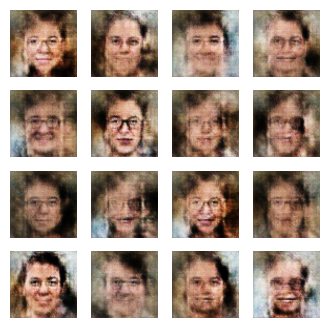

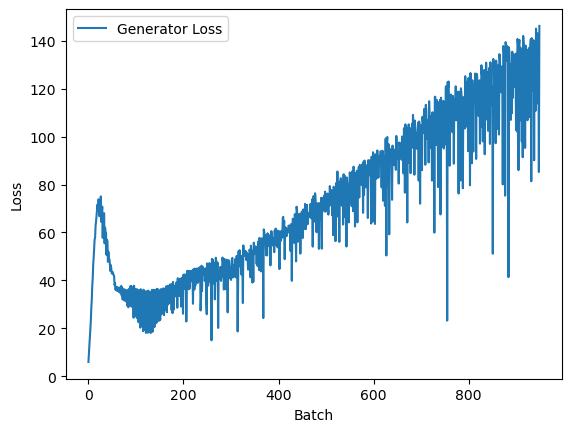

In [12]:
D_losses = []
G_losses = []
EPOCHS = 50
def train(real_dataset, test_input):
    for epoch in range(EPOCHS):
        start = time.perf_counter()
        for batch_idx, images in enumerate(tqdm(real_dataset)):
            for k in range(CRITIC_ITERATIONS):
                noise_input = tf.random.normal([images.shape[0], NOISE_DIMS])
                with tf.GradientTape() as d_tape:
                    generated_output = generator(noise_input, training=True)

                    critic_fake = critic(generated_output, training=True)
                    critic_real = critic(images, training=True)

                    # Calculate Loss
                    gp = gradient_penalty(critic, images, generated_output)
                    d_loss = discriminator_loss(critic_fake, critic_real) + gp * GP_SCALE

                # Calculate gradients
                d_grads = d_tape.gradient(d_loss, critic.trainable_variables)
                # Update weights
                critic_optim.apply_gradients(zip(d_grads, critic.trainable_variables))

            noise_input = tf.random.normal([images.shape[0], NOISE_DIMS])

            with tf.GradientTape() as g_tape:
                generated_output = generator(noise_input, training=True)

                critic_fake = critic(generated_output, training=True)
                # Calculate loss
                g_loss = generator_loss(critic_fake)

            # Calculate gradients
            g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
            # Update weights
            gen_optim.apply_gradients(zip(g_grads, generator.trainable_variables))

            G_losses.append(g_loss)
            
            # Print result for monitoring
            if (batch_idx + 1) % 5 == 0 and batch_idx > 0:
                print(
                    f"Epoch [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(real_dataset)} \
                      Loss D: {d_loss:.4f}, loss G: {g_loss:.4f}"
                )
                
        # Monitor training process
        display.clear_output(wait=True)
        print(f'Traning epoch {epoch} takes {time.perf_counter() - start} seconds')
        generate_and_visualize(test_input, epoch)
        plot_generator_loss(G_losses)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(checkpoint_prefix)

    print('Done!')
    # Display the last result
    display.clear_output(wait=True)
    print(f'Traning epoch {epoch} takes {time.perf_counter() - start} seconds')
    generate_and_visualize(test_input, EPOCHS)
    plot_generator_loss(G_losses)

train(dataset, test_input)

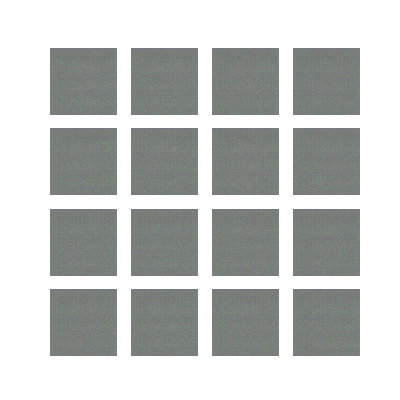

In [13]:
# controls how fast the gif moves through the generated pictures
SPEED = 2

with open('gan.gif', 'w+') as f:
    pass

frames = []
for epoch in range(EPOCHS):
    image = imageio.imread('image_at_epoch_{:04d}.png'.format(epoch))
    frames.append(image)
    
imageio.mimsave('gan.gif', # output gif
                frames,          # array of input frames
               )         # optional: frames per second
    
# this is a hack to display the gif inside the notebook
os.system('cp gan.gif gan.gif.png')

display.Image(filename="gan.gif.png")